In [81]:
import os
import sys
import cv2
import numpy as np
import datetime
from PIL import Image
import pandas as pd 
import subprocess
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

import seaborn as sns
import imageio
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [82]:
from config import *
from postprocess import keep_box_overlaps
from evaluate import evaluate_df
from visualize import get_image_fp,annotate_image
from utils import pad_boxes, add_bottom_right, iou

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
def keep_box_overlaps(df, pad=0, pad_rel= 0,  iou_thresh=0.0):
    # keep only boxes that overlap
    keep_idxs = []
    videos = df['video'].unique()
    #df = add_bottom_right(df)
    pad_array = np.array([-1, -1, 1, 1]) * pad
    
    for video in videos:
        videodf = df[df['video'] == video]
        frames = videodf['frame'].unique()
        for frame in frames:
            framedf = videodf[videodf['frame'] == frame]
            idxs = list(framedf.index)
            values = framedf[['left', 'top', 'right', 'bottom']].values
            for idx1, value1 in zip(idxs, values):
                for idx2, value2 in zip(idxs, values):
                    if idx1 < idx2:
                        w1, h1 = value1[2] - value1[0], value1[3] - value1[1]
                        w2, h2 = value2[2] - value2[0], value2[3] - value2[1]
                        pad_array_rel1 = np.array([-w1, -h1, w1, h1]) * pad_rel
                        pad_array_rel2 = np.array([-w2, -h2, w2, h2]) * pad_rel
                        if iou(value1  + pad_array + pad_array_rel1, value2 + pad_array + pad_array_rel2) > iou_thresh:
                            keep_idxs.extend([idx1, idx2])
    #print(keep_idxs)
    return df.loc[list(set(keep_idxs))]

In [85]:
def count_teams(df, pad=0, iou_thresh=0.0):
    # same team or different team impact
    keep_idxs = []
    videos = df['video'].unique()
    df = add_bottom_right(df)
    pad_array = np.array([-1, -1, 1, 1]) * pad
    same_count = 0
    diff_count = 0
    for video in videos:
        videodf = df[df['video'] == video]
        frames = videodf['frame'].unique()
        for frame in frames:
            framedf = videodf[videodf['frame'] == frame]
            idxs = list(framedf.index)
            values = framedf[['left', 'top', 'right', 'bottom']].values
            for idx1, value1 in zip(idxs, values):
                for idx2, value2 in zip(idxs, values):
                    if idx1 < idx2:
                        if iou(value1 + pad_array, value2 + pad_array) > iou_thresh:
                            keep_idxs.extend([idx1, idx2])
                            if framedf.at[idx1, 'label'][0] == framedf.at[idx2, 'label'][0]:
                                same_count += 1
                            else:
                                diff_count += 1
    print('Same team impact count', same_count)
    print('Diff team impact count', diff_count)
    #print(keep_idxs)
    return df.loc[list(set(keep_idxs))]

In [86]:
%cd ..

/home/anastasiya/Kaggle/NFL/nfl_impact_detection


In [137]:
df = pd.read_csv(train_labels_fp).fillna(0)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/kaggle/train_labels.csv'

In [138]:
df.video.str.split('_').str[0].astype(int)


0         57583
1         57583
2         57583
3         57583
4         57583
          ...  
983880    58107
983881    58107
983882    58107
983883    58107
983884    58107
Name: video, Length: 983885, dtype: int64

In [ ]:
len(df)

In [ ]:
len(df[df['label'] == 'H00'])

In [ ]:
df[df['label'] == 'H00'].head(20)

In [ ]:
count = 0
for i, row in df[df['label'] == 'H00'].drop_duplicates(['video', 'frame']).iterrows():
    video = row['video']
    frame = row['frame']
    image_name = get_image_fp(video, frame)
    videodf = df.query("video == @video and frame == @frame")
    annotate_image(image_name, videodf, videodf[videodf['label'].isin(('H00', 'V00'))])
    count += 1
    if count == 50:
        break


In [88]:
hh = df.query("impact == 1 and visibility > 0 and confidence > 1 and impactType=='Helmet'")

In [89]:
imp = df.query("impact == 1 and visibility > 0 and confidence > 1")
imp_all = df.query("impact == 1")

In [90]:
imp  = add_bottom_right(imp)
#imp = pad_boxes(imp, alpha=1)

In [136]:
len(keep_box_overlaps(imp, pad=2))/len(imp)

0.6694915254237288

In [92]:
len(imp)/len(imp_all) * 100

82.40942819729375

In [93]:
df[df[['video','frame', 'label']].sort_values(['video','frame', 'label']).duplicated(keep=False)]

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
2711,57583,82,Endzone,57583_000082_Endzone.mp4,137,V5,596,24,447,27,0.0,0,0.0,0.0
2717,57583,82,Endzone,57583_000082_Endzone.mp4,137,V5,600,6,477,8,0.0,0,0.0,0.0
3808,57583,82,Endzone,57583_000082_Endzone.mp4,199,V68,419,17,323,9,0.0,0,0.0,0.0
3813,57583,82,Endzone,57583_000082_Endzone.mp4,199,V68,420,17,323,9,0.0,0,0.0,0.0
5973,57583,82,Endzone,57583_000082_Endzone.mp4,309,V68,150,28,212,29,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958891,58104,352,Sideline,58104_000352_Sideline.mp4,28,V53,760,14,327,15,0.0,0,0.0,0.0
958911,58104,352,Sideline,58104_000352_Sideline.mp4,29,V53,760,14,327,16,0.0,0,0.0,0.0
958923,58104,352,Sideline,58104_000352_Sideline.mp4,29,V53,760,14,327,15,0.0,0,0.0,0.0
969174,58107,4362,Endzone,58107_004362_Endzone.mp4,183,V23,677,27,235,26,0.0,0,0.0,0.0


In [94]:
duplicates=df[df[['video','frame', 'label']].sort_values(['video','frame', 'label']).duplicated(keep=False)]

In [95]:
duplicates.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
2711,57583,82,Endzone,57583_000082_Endzone.mp4,137,V5,596,24,447,27,0.0,0,0.0,0.0
2717,57583,82,Endzone,57583_000082_Endzone.mp4,137,V5,600,6,477,8,0.0,0,0.0,0.0
3808,57583,82,Endzone,57583_000082_Endzone.mp4,199,V68,419,17,323,9,0.0,0,0.0,0.0
3813,57583,82,Endzone,57583_000082_Endzone.mp4,199,V68,420,17,323,9,0.0,0,0.0,0.0
5973,57583,82,Endzone,57583_000082_Endzone.mp4,309,V68,150,28,212,29,0.0,0,0.0,0.0


In [96]:
count = 0
for i, row in duplicates.iterrows():
    video = row['video']
    frame = row['frame']
    image_name = get_image_fp(video, frame)
    videodf = duplicates.query("video == @video and frame == @frame")
    print(videodf)
    annotate_image(image_name, videodf)
    count += 1
    if count == 50:
        break


      gameKey  playID     view                     video  frame label  left  \
2711    57583      82  Endzone  57583_000082_Endzone.mp4    137    V5   596   
2717    57583      82  Endzone  57583_000082_Endzone.mp4    137    V5   600   

      width  top  height  impact impactType  confidence  visibility  
2711     24  447      27     0.0          0         0.0         0.0  
2717      6  477       8     0.0          0         0.0         0.0  


FileNotFoundError: No such file: '/home/anastasiya/Kaggle/data/train_images_full/57583_000082_Endzone_137.png'

### How many boxes overlap: all data

In [141]:
len(df)
df = add_bottom_right(df)

In [153]:
len(df)

983885

In [143]:
imp = df.query("impact == 1 and visibility > 0 and confidence > 1")

In [154]:
df_overlap = keep_box_overlaps(df, pad=2, pad_rel=0)

In [155]:
len(df_overlap)/len(df) * 100

28.283894967399647

In [156]:
imp_ = df_overlap.query("impact == 1 and visibility > 0 and confidence > 1")

In [157]:
len(imp_)/len(imp)

0.8802966101694916

### How many boxes overlap: helmet to helmet impacts 

In [97]:
len(hh)

1304

In [98]:
hh_overlap = keep_box_overlaps(hh, pad=2)

KeyError: "['right', 'bottom'] not in index"

In [99]:
len(hh_overlap)/len(hh) * 100

94.47852760736197

In [100]:
count_teams(imp,pad=5)

Same team impact count 41
Diff team impact count 603


,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
639002,57915,3093,Endzone,57915_003093_Endzone.mp4,59,H73,747,5,294,13,1.0,Helmet,3.0,3.0,752,307
155678,57596,2686,Sideline,57596_002686_Sideline.mp4,57,H91,759,12,294,13,1.0,Helmet,3.0,3.0,771,307
155680,57596,2686,Sideline,57596_002686_Sideline.mp4,57,V77,772,15,289,21,1.0,Helmet,3.0,3.0,787,310
639015,57915,3093,Endzone,57915_003093_Endzone.mp4,59,V65,751,24,287,19,1.0,Helmet,3.0,3.0,775,306
147500,57596,2686,Endzone,57596_002686_Endzone.mp4,59,H91,1061,26,321,27,1.0,Helmet,3.0,2.0,1087,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810970,58005,1612,Sideline,58005_001612_Sideline.mp4,63,V84,583,11,240,11,1.0,Helmet,3.0,2.0,594,251
876508,58094,2819,Endzone,58094_002819_Endzone.mp4,185,H55,832,19,303,22,1.0,Helmet,2.0,2.0,851,325
565245,57910,1164,Endzone,57910_001164_Endzone.mp4,85,V77,684,26,251,21,1.0,Helmet,3.0,3.0,710,272
147454,57596,2686,Endzone,57596_002686_Endzone.mp4,56,H90,379,26,307,22,1.0,Helmet,3.0,2.0,405,329


In [101]:
603/644

0.9363354037267081

In [102]:
count_teams(hh,pad=2)

Same team impact count 37
Diff team impact count 579


,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
639002,57915,3093,Endzone,57915_003093_Endzone.mp4,59,H73,747,5,294,13,1.0,Helmet,3.0,3.0,752,307
155678,57596,2686,Sideline,57596_002686_Sideline.mp4,57,H91,759,12,294,13,1.0,Helmet,3.0,3.0,771,307
155680,57596,2686,Sideline,57596_002686_Sideline.mp4,57,V77,772,15,289,21,1.0,Helmet,3.0,3.0,787,310
639015,57915,3093,Endzone,57915_003093_Endzone.mp4,59,V65,751,24,287,19,1.0,Helmet,3.0,3.0,775,306
147500,57596,2686,Endzone,57596_002686_Endzone.mp4,59,H91,1061,26,321,27,1.0,Helmet,3.0,2.0,1087,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810970,58005,1612,Sideline,58005_001612_Sideline.mp4,63,V84,583,11,240,11,1.0,Helmet,3.0,2.0,594,251
876508,58094,2819,Endzone,58094_002819_Endzone.mp4,185,H55,832,19,303,22,1.0,Helmet,2.0,2.0,851,325
565245,57910,1164,Endzone,57910_001164_Endzone.mp4,85,V77,684,26,251,21,1.0,Helmet,3.0,3.0,710,272
147454,57596,2686,Endzone,57596_002686_Endzone.mp4,56,H90,379,26,307,22,1.0,Helmet,3.0,2.0,405,329


In [103]:
579/(579 + 37) * 100

93.9935064935065

In [104]:
hh_overlap.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
639002,57915,3093,Endzone,57915_003093_Endzone.mp4,59,H73,747,5,294,13,1.0,Helmet,3.0,3.0,752,307
155678,57596,2686,Sideline,57596_002686_Sideline.mp4,57,H91,759,12,294,13,1.0,Helmet,3.0,3.0,771,307
155680,57596,2686,Sideline,57596_002686_Sideline.mp4,57,V77,772,15,289,21,1.0,Helmet,3.0,3.0,787,310
639015,57915,3093,Endzone,57915_003093_Endzone.mp4,59,V65,751,24,287,19,1.0,Helmet,3.0,3.0,775,306
147500,57596,2686,Endzone,57596_002686_Endzone.mp4,59,H91,1061,26,321,27,1.0,Helmet,3.0,2.0,1087,348


In [105]:
hh.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
746,57583,82,Endzone,57583_000082_Endzone.mp4,38,H99,582,21,311,27,1.0,Helmet,2.0,2.0,603,338
754,57583,82,Endzone,57583_000082_Endzone.mp4,38,V68,562,18,313,15,1.0,Helmet,2.0,2.0,580,328
967,57583,82,Endzone,57583_000082_Endzone.mp4,49,H97,425,15,311,20,1.0,Helmet,3.0,3.0,440,331
969,57583,82,Endzone,57583_000082_Endzone.mp4,49,V72,434,18,316,15,1.0,Helmet,3.0,3.0,452,331
1149,57583,82,Endzone,57583_000082_Endzone.mp4,58,H90,238,18,299,31,1.0,Helmet,3.0,3.0,256,330


In [106]:
hh_not_overlap = hh.loc[~hh.index.isin(hh_overlap.index)].sort_values(['video', 'frame'])

#### how much we need to pad boxes so all of them overlap during helmet to helmet impact

In [107]:
hh_pad = pad_boxes(hh, delta=2)

In [108]:
len(keep_box_overlaps(hh_pad))/len(hh)

0.9447852760736196

In [109]:
hh_pad = pad_boxes(hh, delta=5)
len(keep_box_overlaps(hh_pad))/len(hh)

0.9585889570552147

In [110]:
hh.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
746,57583,82,Endzone,57583_000082_Endzone.mp4,38,H99,575,35,304,41,1.0,Helmet,2.0,2.0,610,345
754,57583,82,Endzone,57583_000082_Endzone.mp4,38,V68,555,32,306,29,1.0,Helmet,2.0,2.0,587,335
967,57583,82,Endzone,57583_000082_Endzone.mp4,49,H97,418,29,304,34,1.0,Helmet,3.0,3.0,447,338
969,57583,82,Endzone,57583_000082_Endzone.mp4,49,V72,427,32,309,29,1.0,Helmet,3.0,3.0,459,338
1149,57583,82,Endzone,57583_000082_Endzone.mp4,58,H90,231,32,292,45,1.0,Helmet,3.0,3.0,263,337


In [111]:
hh_pad.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,right,bottom
746,57583,82,Endzone,57583_000082_Endzone.mp4,38,H99,575,35,304,41,1.0,Helmet,2.0,2.0,610,345
754,57583,82,Endzone,57583_000082_Endzone.mp4,38,V68,555,32,306,29,1.0,Helmet,2.0,2.0,587,335
967,57583,82,Endzone,57583_000082_Endzone.mp4,49,H97,418,29,304,34,1.0,Helmet,3.0,3.0,447,338
969,57583,82,Endzone,57583_000082_Endzone.mp4,49,V72,427,32,309,29,1.0,Helmet,3.0,3.0,459,338
1149,57583,82,Endzone,57583_000082_Endzone.mp4,58,H90,231,32,292,45,1.0,Helmet,3.0,3.0,263,337


### Look at impacts when helmets dont overlap

In [112]:
count = 0
for i, row in hh_not_overlap.drop_duplicates(['video', 'frame']).iterrows():
    video = row['video']
    frame = row['frame']
    image_name = get_image_fp(video, frame)
    videodf = df.query("video == @video and frame == @frame")
    print(videodf.query("impact ==1"))
    print(keep_box_overlaps(videodf.query("impact ==1")))
    annotate_image(image_name, videodf.query("impact ==0"), videodf.query("impact ==1"))
    count += 1
    if count == 10:
        break


       gameKey  playID      view                      video  frame label  \
10323    57583      82  Sideline  57583_000082_Sideline.mp4     83   H96   

       left  width  top  height  impact impactType  confidence  visibility  
10323   423     13  383      14     1.0     Helmet         3.0         1.0  


KeyError: "['right', 'bottom'] not in index"

In [113]:
# 

### helmet width/height during impact vs average weight/height

In [114]:
df.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,0.0,0,0.0,0.0
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,0.0,0,0.0,0.0
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,0.0,0,0.0,0.0
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,0.0,0,0.0,0.0
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,0.0,0,0.0,0.0


In [115]:
meandf = df.groupby(['video', 'frame']).mean()[['width', 'height']].reset_index().rename(columns={'width': 'mean_w', 'height': 'mean_h'})

In [116]:
df = df.merge(meandf, on=['video', 'frame'])

In [117]:
df['w_ratio'] = df['width']/df['mean_w']
df['h_ratio'] = df['height']/df['mean_h']

<AxesSubplot:>

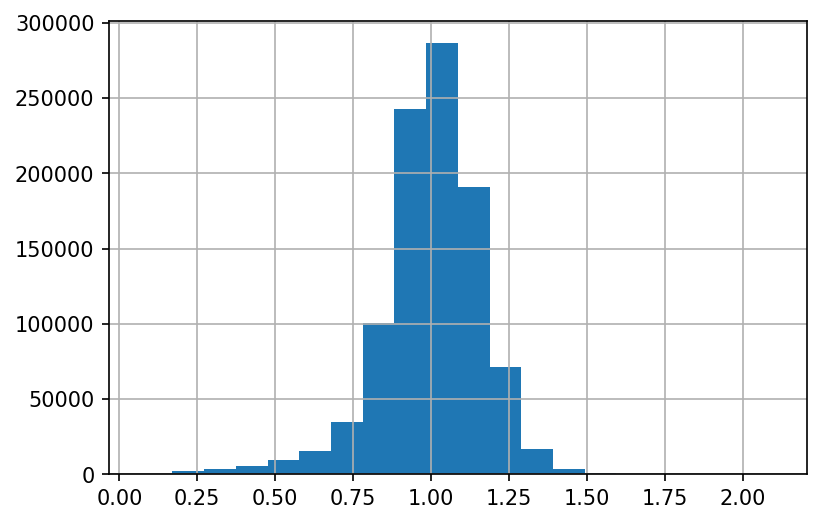

In [118]:
df['w_ratio'].hist(bins=20)

<AxesSubplot:>

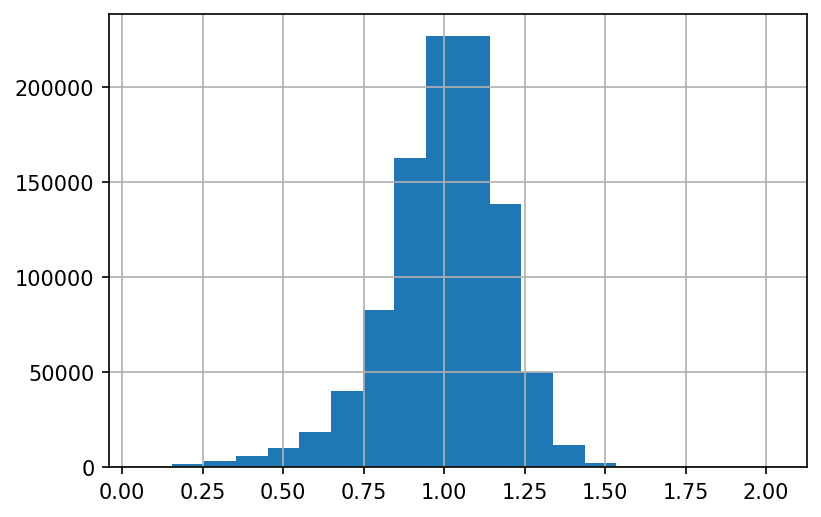

In [119]:
df['h_ratio'].hist(bins=20)

In [120]:
hh = df.query("impact == 1 and visibility > 0 and confidence > 1 and impactType=='Helmet'")

In [121]:
len(hh[hh['w_ratio'] > 0.6])/len(hh)

0.9539877300613497

<AxesSubplot:>

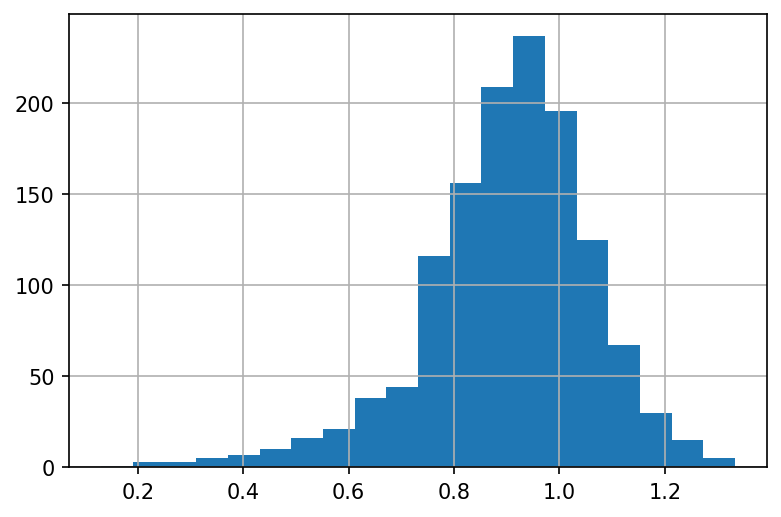

In [122]:
hh['w_ratio'].hist(bins=20)

<AxesSubplot:>

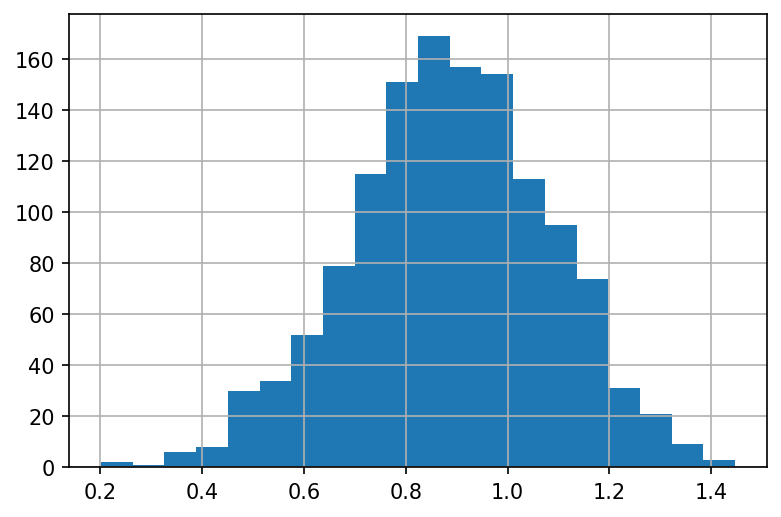

In [123]:
hh['h_ratio'].hist(bins=20)

In [124]:
video, frame = "57784_001741_Sideline.mp4", 70

In [125]:
image_fp  = get_image_fp(video, frame)

In [126]:
df.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,mean_w,mean_h,w_ratio,h_ratio
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,0.0,0,0.0,0.0,20.45,22.15,0.929095,1.083521
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,0.0,0,0.0,0.0,20.45,22.15,1.075795,0.722348
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,0.0,0,0.0,0.0,20.45,22.15,1.026895,0.767494
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,0.0,0,0.0,0.0,20.45,22.15,0.929095,0.677201
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,0.0,0,0.0,0.0,20.45,22.15,1.271394,0.902935


In [127]:
df.query("video==@video and frame==@frame")

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,mean_w,mean_h,w_ratio,h_ratio
410054,57784,1741,Sideline,57784_001741_Sideline.mp4,70,H77,760,20,318,21,1.0,Helmet,2.0,1.0,19.818182,20.227273,1.009174,1.038202
410055,57784,1741,Sideline,57784_001741_Sideline.mp4,70,V51,656,22,296,22,0.0,0,0.0,0.0,19.818182,20.227273,1.110092,1.087640
410056,57784,1741,Sideline,57784_001741_Sideline.mp4,70,V91,735,20,231,21,0.0,0,0.0,0.0,19.818182,20.227273,1.009174,1.038202
410057,57784,1741,Sideline,57784_001741_Sideline.mp4,70,H72,754,20,231,20,0.0,0,0.0,0.0,19.818182,20.227273,1.009174,0.988764
410058,57784,1741,Sideline,57784_001741_Sideline.mp4,70,H75,801,21,347,22,0.0,0,0.0,0.0,19.818182,20.227273,1.059633,1.087640
410059,57784,1741,Sideline,57784_001741_Sideline.mp4,70,H60,736,20,282,18,0.0,0,0.0,0.0,19.818182,20.227273,1.009174,0.889888
410060,57784,1741,Sideline,57784_001741_Sideline.mp4,70,V93,778,20,351,20,0.0,0,0.0,0.0,19.818182,20.227273,1.009174,0.988764
410061,57784,1741,Sideline,57784_001741_Sideline.mp4,70,V95,743,19,327,20,1.0,Helmet,2.0,1.0,19.818182,20.227273,0.958716,0.988764
410062,57784,1741,Sideline,57784_001741_Sideline.mp4,70,V92,715,20,275,18,0.0,0,0.0,0.0,19.818182,20.227273,1.009174,0.889888
410063,57784,1741,Sideline,57784_001741_Sideline.mp4,70,H69,750,18,311,18,0.0,0,0.0,0.0,19.818182,20.227273,0.908257,0.889888


In [128]:
annotate_image(image_fp, df.query("video==@video and frame==@frame"))

FileNotFoundError: No such file: '/home/anastasiya/Kaggle/data/train_images_full/57784_001741_Sideline_70.png'

In [129]:
train_labels

NameError: name 'train_labels' is not defined